In [1]:
import os, sys
from subprocess import check_output
from functools import partial
import numpy as np, scipy as sp
import pandas as pd
import itertools

import pickle, gc
from datetime import datetime
from sklearn.model_selection import train_test_split, KFold, cross_validate
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, cohen_kappa_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, brier_score_loss
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, RFE, RFECV, chi2, f_classif, f_regression

import xgboost as xgb
import glob, subprocess, copy
import pyarrow.parquet as pq
import json

In [2]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot as plyplot, iplot as plyiplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
from plotly import tools as plytls

In [3]:
from matplotlib import pyplot as plt
%matplotlib inline
from IPython.display import display, Markdown, Latex
from bokeh.plotting import figure, output_file, show
import seaborn as sns

In [5]:
%%javascript

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('Ctrl-l', {
    help : 'clear output',
    help_index : 'zz',
    handler : function (event) {
        Jupyter.notebook.clear_output();
        return false;
    }}
);

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('Ctrl-Shift-l', {
    help : 'clear cells outputs',
    help_index : 'zz',
    handler : function (event) {
        Jupyter.notebook.clear_cells_outputs();
        return false;
    }}
); 

Jupyter.keyboard_manager.command_shortcuts.add_shortcut('Ctrl-z', {
    help : 'undo delete cells',
    help_index : 'zz',
    handler : function (event) {
        Jupyter.notebook.undelete_cell();
        return false;
    }}
); 

<IPython.core.display.Javascript object>

In [6]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)

In [7]:
from keras.models import Model, Sequential
from keras.layers import GRU, LSTM, SimpleRNN
from keras.layers import Input, Dropout, Dense, Reshape, Flatten, Activation
from keras.layers.merge import _Merge
from keras.layers import Conv1D, Conv2D
from keras.layers.convolutional import Convolution2D, Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.layers import TimeDistributed, RepeatVector
from keras.layers.advanced_activations import LeakyReLU, ReLU, ThresholdedReLU
from keras.layers import Add, Concatenate, Lambda, Dot
from keras import optimizers
from keras import losses
from keras.datasets import mnist
from keras.utils import np_utils
from keras.preprocessing import sequence as ksq
from keras import backend as K
from functools import partial
from keras.callbacks import EarlyStopping

from keras.preprocessing.text import *
from keras.preprocessing.sequence import *

Using TensorFlow backend.


# Load Data

In [8]:
data_dir = "./"

In [9]:
sss = pd.read_csv(os.path.join(data_dir, "ssss.csv"), header=0)

In [10]:
sss.head()

,Sequence,label
0,KAKVAKPK,1
1,HGRKFVQGKSIDVACHPG,1
2,FGGPGTASRP,1
3,EPDREYHFGQAVRFV,1
4,KKLIELQAGKKSLED,1


In [11]:
vocab =  set(''.join(list(sss['Sequence'])+['Z', 'X', '-']))

In [12]:
vocab_dict = dict(zip(sorted(list(vocab)), 1+np.arange(len(list(vocab)))))

In [13]:
reverse_vocab_dict = {vocab_dict[x]: x for x in vocab_dict}

In [14]:
reverse_vocab_dict

{1: '-',
 2: 'A',
 3: 'B',
 4: 'C',
 5: 'D',
 6: 'E',
 7: 'F',
 8: 'G',
 9: 'H',
 10: 'I',
 11: 'K',
 12: 'L',
 13: 'M',
 14: 'N',
 15: 'P',
 16: 'Q',
 17: 'R',
 18: 'S',
 19: 'T',
 20: 'V',
 21: 'W',
 22: 'X',
 23: 'Y',
 24: 'Z'}

In [15]:
df_sequences = sss

In [16]:
df_real = df_sequences[df_sequences['label']==1]
df_fake = df_sequences[df_sequences['label']==0]

In [17]:
ssr = list(df_real['Sequence'])
ssf = list(df_fake['Sequence'])

## Transform sequence list

In [18]:
seq_len = max([len(x) for x in ssr+ssf])

In [19]:
print(seq_len)

25


In [20]:
nsample_real = len(ssr)
nsample_fake = len(ssf)

In [21]:
vocab_size = len(list(vocab))-1

In [22]:
ssrx = [x+'-'*(seq_len-len(x)) for x in ssr]
ssfx = [x+'-'*(seq_len-len(x)) for x in ssf]

In [23]:
oh_ssrx = list()
for padded_seq in ssrx:
    oh_padded_seq = [[0]*vocab_size for aa in padded_seq]
    for iaa in range(seq_len):
        aa = padded_seq[iaa]
        enc = vocab_dict[aa]
        if enc <= vocab_size:
            oh_padded_seq[iaa][enc-1]=1
    oh_ssrx.append(oh_padded_seq)

oh_ssrx_arr = np.asarray(oh_ssrx)

In [24]:
oh_ssfx = list()
for padded_seq in ssfx:
    oh_padded_seq = [[0]*vocab_size for aa in padded_seq]
    for iaa in range(seq_len):
        aa = padded_seq[iaa]
        enc = vocab_dict[aa]
        if enc <= vocab_size:
            oh_padded_seq[iaa][enc-1]=1
    oh_ssfx.append(oh_padded_seq)

oh_ssfx_arr = np.asarray(oh_ssfx)

In [25]:
print(oh_ssrx_arr.shape, oh_ssfx_arr.shape)

(4500, 25, 23) (31453, 25, 23)


In [26]:
trt_X = np.concatenate([oh_ssrx_arr,oh_ssfx_arr])
trt_y = np.array([1]*oh_ssrx_arr.shape[0] + [0]*oh_ssfx_arr.shape[0])

In [27]:
print(trt_X.shape, trt_y.shape)

(35953, 25, 23) (35953,)


## Train-Test Split

In [28]:
train_X, test_X, train_y, test_y = train_test_split(trt_X, trt_y, test_size=0.33, random_state=42)

## Build Keras Model

In [29]:
batch_size = 64
epochs = 50
latent_dim = 6
num_samples = train_X.shape[0]

In [30]:
feature_dim = train_X.shape[-1]
sequence_lenth = seq_len

In [31]:
def build_rnnseq_model(base=SimpleRNN, activation=LeakyReLU(alpha=0.6), kernal_activation=None, 
                feature_dim=feature_dim, latent_dim=latent_dim, hidden_units=[]):
    encoder_inputs = Input(shape=(sequence_lenth, feature_dim))
    if activation is None:
        activation = lambda x: x
    if len(hidden_units) == 0:
        encoder_outputs = base(latent_dim, return_sequences=True, activation=kernal_activation)(encoder_inputs)
        encoder_outputs = BatchNormalization()(encoder_outputs)
        encoder_outputs = activation(encoder_outputs)
    else:
        encoder_outputs = base(hidden_units[0], return_sequences=True, activation=kernal_activation)(encoder_inputs)
        encoder_outputs = BatchNormalization()(encoder_outputs)
        encoder_outputs = activation(encoder_outputs)
        # hidden_units.append(latent_dim)
        for this_hidden_units in hidden_units[1:]:
            encoder_outputs = base(this_hidden_units, return_sequences=True, activation=kernal_activation)(encoder_outputs)
            encoder_outputs = BatchNormalization()(encoder_outputs)
            encoder_outputs = activation(encoder_outputs)
    # encoder_outputs = Reshape(())(encoder_outputs)
    # encoder_outputs = Flatten()(encoder_outputs)
    
    # dense_output = TimeDistributed(Dense(1, activation="sigmoid"))(encoder_outputs)
    encoder_outputs = Flatten()(encoder_outputs)
    encoder_outputs = BatchNormalization()(encoder_outputs)
    dense_output = Dense(1, activation='sigmoid')(encoder_outputs)
    return Model(encoder_inputs, dense_output)

In [32]:
model = build_rnnseq_model(base=LSTM, activation=None, kernal_activation='tanh', hidden_units=[10, 4])

In [33]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 25, 23)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 25, 10)            1360      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25, 10)            40        
_________________________________________________________________
lstm_2 (LSTM)                (None, 25, 4)             240       
_________________________________________________________________
batch_normalization_2 (Batch (None, 25, 4)             16        
_________________________________________________________________
flatten_1 (Flatten)          (None, 100)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100)               400       
__________

In [34]:
model.compile(optimizer='adadelta', loss='binary_crossentropy')

In [35]:
model.fit(train_X, train_y, batch_size=batch_size, epochs=100, validation_data=(test_X, test_y)
         , callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)])

Train on 24088 samples, validate on 11865 samples
Epoch 1/100
24088/24088 [==============================] - 14s 598us/step - loss: 0.3691 - val_loss: 0.2888
Epoch 2/100
24088/24088 [==============================] - 13s 525us/step - loss: 0.2652 - val_loss: 0.2546
Epoch 3/100
24088/24088 [==============================] - 12s 516us/step - loss: 0.2444 - val_loss: 0.2405
Epoch 4/100
24088/24088 [==============================] - 12s 512us/step - loss: 0.2322 - val_loss: 0.2298
Epoch 5/100
24088/24088 [==============================] - 13s 522us/step - loss: 0.2225 - val_loss: 0.2247
Epoch 6/100
24088/24088 [==============================] - 12s 516us/step - loss: 0.2153 - val_loss: 0.2202
Epoch 7/100
24088/24088 [==============================] - 12s 516us/step - loss: 0.2102 - val_loss: 0.2186
Epoch 8/100
24088/24088 [==============================] - 12s 516us/step - loss: 0.2058 - val_loss: 0.2136
Epoch 9/100
24088/24088 [==============================] - 12s 519us/step - loss: 0.20

In [36]:
roc_auc_score(test_y, model.predict(test_X))

0.9249007316635943

In [37]:
test_y_hat = model.predict(test_X).reshape((test_X.shape[0],))

In [38]:
roc_auc_score(test_y, test_y_hat)

0.9249007316635943

In [39]:
metric.enhanced_gini(true=test_y, pred=test_y_hat)

0.8498014633271888

In [40]:
metric.accuracy_index(true=test_y, pred=test_y_hat)

0.8730914765388094

In [41]:
fpr, tpr, threshold = roc_curve(test_y, test_y_hat)
roc_auc = auc(fpr, tpr)

In [129]:
pd.DataFrame([fpr,tpr], index=['fpr', 'tpr']).T

,fpr,tpr
0,0.000000,0.000000
1,0.000000,0.000672
2,0.000000,0.004704
3,0.000000,0.006720
4,0.000000,0.007392
5,0.000000,0.008737
6,0.000000,0.016129
7,0.000000,0.017473
8,0.000000,0.025538
9,0.000096,0.025538


In [130]:
pd.DataFrame([fpr,tpr], index=['fpr', 'tpr']).T.to_csv(
'/axp/rim/gbmml/dev/zma14.ads/xtmp/OMSCS/rnn_roc.csv', index=False, header=True
)

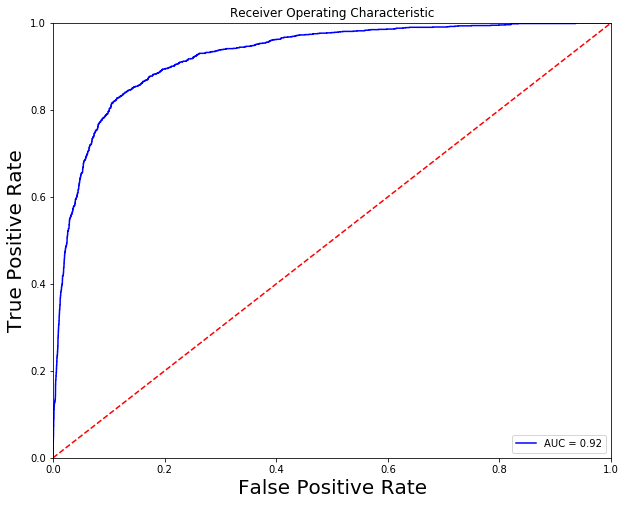

In [110]:
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', size=20)
plt.xlabel('False Positive Rate', size=20)
plt.show()

#### SimpleRNN

In [43]:
model2 = build_rnnseq_model(base=SimpleRNN, activation=None, kernal_activation='tanh', hidden_units=[10, 4])

In [44]:
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 25, 23)            0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 25, 10)            340       
_________________________________________________________________
batch_normalization_4 (Batch (None, 25, 10)            40        
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 25, 4)             60        
_________________________________________________________________
batch_normalization_5 (Batch (None, 25, 4)             16        
_________________________________________________________________
flatten_2 (Flatten)          (None, 100)               0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100)               400       
__________

In [45]:
model2.compile(optimizer='adadelta', loss='binary_crossentropy')

In [46]:
model2.fit(train_X, train_y, batch_size=batch_size, epochs=100, validation_data=(test_X, test_y)
         , callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)])

Train on 24088 samples, validate on 11865 samples
Epoch 1/100
24088/24088 [==============================] - 5s 226us/step - loss: 0.4094 - val_loss: 0.3173
Epoch 2/100
24088/24088 [==============================] - 4s 177us/step - loss: 0.2911 - val_loss: 0.2801
Epoch 3/100
24088/24088 [==============================] - 4s 173us/step - loss: 0.2620 - val_loss: 0.2626
Epoch 4/100
24088/24088 [==============================] - 4s 174us/step - loss: 0.2436 - val_loss: 0.2452
Epoch 5/100
24088/24088 [==============================] - 4s 168us/step - loss: 0.2323 - val_loss: 0.2365
Epoch 6/100
24088/24088 [==============================] - 4s 173us/step - loss: 0.2256 - val_loss: 0.2600
Epoch 7/100
24088/24088 [==============================] - 4s 176us/step - loss: 0.2218 - val_loss: 0.2317
Epoch 8/100
24088/24088 [==============================] - 4s 171us/step - loss: 0.2171 - val_loss: 0.2273
Epoch 9/100
24088/24088 [==============================] - 4s 172us/step - loss: 0.2138 - val_

In [47]:
roc_auc_score(test_y, model2.predict(test_X))

0.9163339156799415

In [48]:
test_y_hat2 = model2.predict(test_X).reshape((test_X.shape[0],))

In [49]:
roc_auc_score(test_y, test_y_hat2)

0.9163339156799415

In [50]:
fpr2, tpr2, threshold2 = roc_curve(test_y, test_y_hat2)
roc_auc2 = auc(fpr2, tpr2)

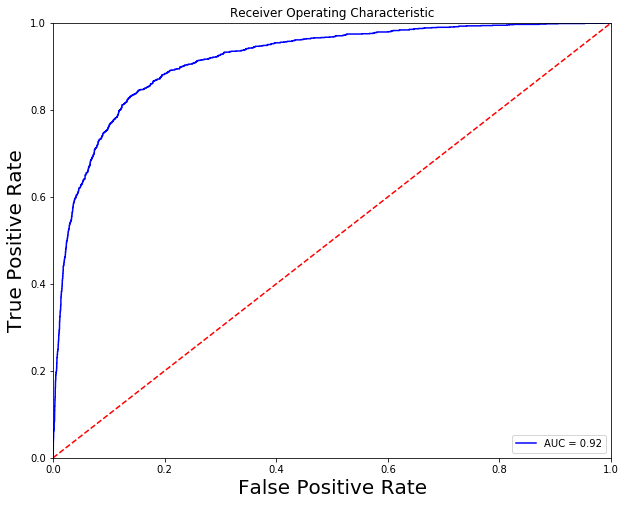

In [66]:
plt.figure(figsize=(10,8))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr2, tpr2, 'b', label = 'AUC = %0.2f' % roc_auc2)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate', size=20)
plt.xlabel('False Positive Rate', size=20)
plt.show()

## Classification on GAN-generated Sequences

In [73]:
df_gen = pd.read_csv(os.path.join(data_dir, "generated_sequences_2ndBatch.csv"), header=0)

In [53]:
ssg = list(df_gen['Sequence'])

In [54]:
ssgx = [x+'-'*(seq_len-len(x)) for x in ssg]

In [55]:
oh_ssgx = list()
for padded_seq in ssgx:
    oh_padded_seq = [[0]*vocab_size for aa in padded_seq]
    for iaa in range(seq_len):
        aa = padded_seq[iaa]
        enc = vocab_dict[aa]
        if enc <= vocab_size:
            oh_padded_seq[iaa][enc-1]=1
    oh_ssgx.append(oh_padded_seq)

oh_ssgx_arr = np.asarray(oh_ssgx)

In [56]:
print(oh_ssgx_arr.shape)

(100000, 25, 23)


In [67]:
gen_X = oh_ssgx_arr

In [68]:
gen_y_hat = model.predict(gen_X).reshape((gen_X.shape[0],))

In [69]:
gen_y_hat[gen_y_hat>=0.2].shape

(95050,)

In [70]:
df_gen_seq_hat = pd.DataFrame(list(zip(ssg, gen_y_hat)), columns=['Sequence', 'pred'])

In [71]:
cutoff = 0.2
df_gen_seq_hat[df_gen_seq_hat['pred']>=cutoff].sort_values(by='pred', ascending=False)

,Sequence,pred
18747,TSTMSSSKSTSSTTTKKGGGGGGGG,0.999827
91889,TQTMSSSSKTSSTTGKGGGGGGGGG,0.999729
31873,TTTMSSSKSSSTTTGGGGGGGGGGG,0.999661
52022,TQTMSSSSTKSTTSGGGGGGGGGGG,0.999581
34196,TTTDSSSSSSTTTKGGGGGGGGGGG,0.999541
91609,TQTMSSSSSSSTTSSGGGGGGGGGG,0.999509
52318,TTTSSSSTTSSSTBTKGGGGGGGGG,0.999502
81021,TSTTDSSSSSSSTSSKGGGGGGGGG,0.999489
72354,TTTTSSSSSSTKSTGGGGGGGGGGG,0.999467
5898,TSTDDSSTTSSTTSSKKKGGGGGGG,0.999465


## Classification on TableS13

In [76]:
df_val = pd.read_excel(os.path.join(data_dir, "41587_2019_280_MOESM3_ESM.xlsx"), sheet_name='TableS13', skiprows=1)

In [77]:
df_val.head()

,Gene,HLA-II ligand sequence,Dataset,MARIA percentile score,MARIA medium/high (>95th percentile),IEDB recommended CD4 rank
0,KRAS,MTEYKLVVVGARGVGKSALTIQLIQNH,Iiizumi et al. 2019,99.78,1,41.62
1,KIT,GRITKICDFGLARVIKNDSNYVVKGNA,Iiizumi et al. 2019,98.28,1,30.73
2,PIK3CA,EALEYFMKQMNDARHGGWTTKMDWIFH,Iiizumi et al. 2019,98.13,1,40.38
3,ARHGAP35,HNLDLAEKDFMVNTVAGAMK,Keskin et al. 2019,99.63,1,39.41
4,SVEP1,GPPAHVENAIARGIHYQYGDMITYS,Keskin et al. 2019,95.81,1,44.07


In [78]:
ssv = list(df_val['HLA-II ligand sequence'])

In [87]:
ssvx = [k[0:25] for k in [x+'-'*(seq_len-len(x)) for x in ssv]]

In [88]:
ssvx

['MTEYKLVVVGARGVGKSALTIQLIQ',
 'GRITKICDFGLARVIKNDSNYVVKG',
 'EALEYFMKQMNDARHGGWTTKMDWI',
 'HNLDLAEKDFMVNTVAGAMK-----',
 'GPPAHVENAIARGIHYQYGDMITYS',
 'SEMEENLANRSHAKLETALRDSSRV',
 'KPYQPQVDGEIPLHRSDRVKVLSIG',
 'WLSSSFMGLSQNLLLRSPGFRQL--',
 'HRVAGEDMLVWRWTKLSSFSDSER-',
 'CGKTALLHVFAKDCFSENYVPTVFE',
 'GLCKIDREGKPRKVIGCSCVVVKDY',
 'YFSCGKLDLSVTEAAVAGIAKACGK',
 'NCTWGMNCRFIHPRVNDKGNYSLIT',
 'RLQRQLKQERDYLVFLQHQRQEQRP',
 'LAELPQKPPPGDLPLKPTELAPKPQ',
 'EVKNYDAALRKITFLHRCLISCSKK',
 'KVSLPDGAEGSGTDYRSSSSHSPGS',
 'QLAKAQLQKGMVKKAIDSYIKADDP',
 'AYEEDENWPEIFVKGYIEDSLGERI',
 'TFLPTGITFKSVTRKDTGTYTCMVS',
 'TIKNKNNFIQTKSISKSENECVFVQ',
 'FLDTHSITFTTAATHREKLQGRRRQ',
 'LLVLKSLAYRNKGLFDEAAKIMEDL',
 'GEEDEEGEGDDGYKQISSDEDGIAD',
 'SLDPRRQELLEARFTGVASGSTGST',
 'ERAGVRTYVSTIRISIRRILNTGLS',
 'PVQFFGGWYFYIQTYKALKHKTANM',
 'DFIPRLDPRYTTVTPKLPTEFS---',
 'CVAAILGETEVQQLLRQAQRGTEEK',
 'TSCSDIRQFCKKIPRRMPGTDAPGI',
 'ASSVTVTRSYRSGGGSGGGSFGDNL',
 'AAKFMRKRRKGQHCRMEIIHEIAVL',
 'DKVSHSEDDCLAFKAHQYFNVELIQ',
 'WTADFSGD

In [89]:
oh_ssvx = list()
for padded_seq in ssvx:
    oh_padded_seq = [[0]*vocab_size for aa in padded_seq]
    for iaa in range(seq_len):
        aa = padded_seq[iaa]
        enc = vocab_dict[aa]
        if enc <= vocab_size:
            oh_padded_seq[iaa][enc-1]=1
    oh_ssvx.append(oh_padded_seq)

oh_ssvx_arr = np.asarray(oh_ssvx)

In [91]:
print(oh_ssvx_arr.shape)

(521, 25, 23)


In [92]:
val_X = oh_ssvx_arr

In [93]:
val_y_hat = model.predict(val_X).reshape((val_X.shape[0],))

In [95]:
df_val_seq_hat = pd.DataFrame(list(zip(ssv, val_y_hat)), columns=['Sequence', 'pred'])

In [96]:
cutoff = 0.2
df_val_seq_hat[df_val_seq_hat['pred']>=cutoff].sort_values(by='pred', ascending=False)

,Sequence,pred
470,VAPASEPSLSPSTTKKTSECQSPLPSTAT,0.998827
485,TPSATTLDPSSASVPPETTAAPPTPSATT,0.997045
140,ALHPALGAYEQAAGHPFSAGLPPAASCPE,0.996227
211,EEREEIEKQALEKPKRSSKTFKEMLQDRE,0.994400
77,TSAEYIPLTPAAADVNGSPRPSP,0.993645
81,ERKWFKVPSKKEVTSTCIATPDVEK,0.993500
227,KPSPAVNLRTGKAELTQHPEKENEGDITI,0.992452
239,SAPTTAASSTTVSSIAPTTAASSMT,0.991623
520,LLASSDPPALASTNAEVTGTMSQDT,0.991582
271,SGSSSSPISLSTEKKTSFLSPTASTSRKT,0.991237


In [100]:
df_val_pred = df_val.merge(df_val_seq_hat, left_on='HLA-II ligand sequence', right_on='Sequence', how='inner')

In [114]:
df_val_pred_core = df_val_pred[['HLA-II ligand sequence', 'IEDB recommended CD4 rank', 'pred']].copy()

In [115]:
df_val_pred_core.sort_values(by='IEDB recommended CD4 rank', ascending=False)

,HLA-II ligand sequence,IEDB recommended CD4 rank,pred
90,KKAEGAQNQGKKGEGAQNQGKKAEG,93.06,0.693175
382,GESRPETPKQKSEGHPETPKQKGDG,92.90,0.711244
337,LNQEEFTDGEEEEEEDTAAGEPSRDTRGA,90.31,0.971473
492,YIAEGESDTDSDLCPPCGPPPRSATGEGP,89.99,0.769558
434,GPAGPHIPPSDEICKPGPPGPPGSPGDKG,89.35,0.988042
500,SPQPEESHLSPQPEEPCLSPRPEES,88.59,0.925587
352,GATGEDEDKSRERCDAGNSRSEDSPAGVT,88.58,0.192357
193,PKVTPQEEADSDVVEEPDSENTPQKADKD,87.40,0.807703
477,MARPSGSSEATGKPR,85.62,0.098727
445,MASPSGSSEVTGKPRGRDGRPR,85.01,0.976711


In [116]:
df_val_pred_core.sort_values(by='pred', ascending=False)

,HLA-II ligand sequence,IEDB recommended CD4 rank,pred
470,VAPASEPSLSPSTTKKTSECQSPLPSTAT,78.85,0.998827
485,TPSATTLDPSSASVPPETTAAPPTPSATT,70.68,0.997045
140,ALHPALGAYEQAAGHPFSAGLPPAASCPE,53.93,0.996227
211,EEREEIEKQALEKPKRSSKTFKEMLQDRE,59.19,0.994400
77,TSAEYIPLTPAAADVNGSPRPSP,50.32,0.993645
81,ERKWFKVPSKKEVTSTCIATPDVEK,47.09,0.993500
227,KPSPAVNLRTGKAELTQHPEKENEGDITI,61.78,0.992452
239,SAPTTAASSTTVSSIAPTTAASSMT,59.72,0.991623
520,LLASSDPPALASTNAEVTGTMSQDT,64.03,0.991582
271,SGSSSSPISLSTEKKTSFLSPTASTSRKT,52.15,0.991237


In [121]:
df_val_pred_core[(df_val_pred_core['IEDB recommended CD4 rank']>=70) & (df_val_pred_core['pred']>=0.70)]

,HLA-II ligand sequence,IEDB recommended CD4 rank,pred
23,GEEDEEGEGDDGYKQISSDEDGIADLERE,77.10,0.833580
184,GLGRALPPEVKVEGLKEELEVAGERGFVP,75.24,0.854155
186,GTISENTNYNHPPEADSAGTAFNLG,76.71,0.820404
193,PKVTPQEEADSDVVEEPDSENTPQKADKD,87.40,0.807703
241,SEQEPVQGVEPLQGTSQGPKEPQPSPTDQ,73.30,0.893915
276,RRSSTSGDTEEEEEEVVPFSSDEQKRRSE,71.15,0.889778
296,AGPHKSHLHPGSSERERCSPPPGGASAGG,81.64,0.990213
327,IADVPSDTSKNDKKEKANTAKANVTPQSS,78.70,0.934758
337,LNQEEFTDGEEEEEEDTAAGEPSRDTRGA,90.31,0.971473
382,GESRPETPKQKSEGHPETPKQKGDG,92.90,0.711244
